In [1]:
### nb snps in ee normalized by size of exon 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
from statannot import add_stat_annotation
import seaborn as sns
matplotlib.rcParams['pdf.fonttype'] = 42

### cEEs
df = pd.read_csv("/mnt/project/exonhancer/ZENODO_REPO/gnomADv3_analysis/3_raw_vcf/ee_gnomad_count_hg38.tsv", sep='\t', header=0)
df_ee = df[["GroupByTF", "gnomAD_SNPs", "Size"]].copy()

df_ee["gnomAD_SNPs_norm"] = df_ee["gnomAD_SNPs"] / df_ee["Size"]

df_ee_2 = df_ee[["gnomAD_SNPs_norm"]]
df_ee_2["Dataset"] = "cEEs"

# Remove extreme values (outliers) based on the normalized column
lower_quantile = df_ee["gnomAD_SNPs_norm"].quantile(0.05)  # Lower 5%
upper_quantile = df_ee["gnomAD_SNPs_norm"].quantile(0.95)  # Upper 95%

df_ee_filtered = df_ee[
    (df_ee["gnomAD_SNPs_norm"] >= lower_quantile) & 
    (df_ee["gnomAD_SNPs_norm"] <= upper_quantile)
]

### Neg
dic_neg_size = {}
with open("/mnt/project/exonhancer/ZENODO_REPO/Control_selection/control_neg_NoTF_NoTSS_TES_prom.tsv") as file:
    for line in file:           
        dic_neg_size[line.strip().split()[3]] = int(line.strip().split()[2]) - int(line.strip().split()[1])

res_neg = []
with open('/mnt/project/exonhancer/ZENODO_REPO/gnomADv3_analysis/3_raw_vcf/gnomad_nb_snp_neg.tsv') as file:
    for line in file:      
        if line.strip().split()[1] == "total":
            continue     
        exon = ".".join((line.strip().split()[1]).split(".")[:-1])
        res_neg.append(int(line.strip().split()[0]) / dic_neg_size[exon])

df_neg = pd.DataFrame({"gnomAD_SNPs_norm":res_neg})
df_neg["Dataset"] = "Ctrl-"

### Pos
dic_pos_size = {}
with open("/mnt/project/exonhancer/ZENODO_REPO/Control_selection/control_pos_enhD_NoTSS_TES_10TFmin.tsv") as file:
    for line in file:           
        dic_pos_size[line.strip().split()[3]] = int(line.strip().split()[2]) - int(line.strip().split()[1])

res_pos = []
with open('/mnt/project/exonhancer/ZENODO_REPO/gnomADv3_analysis/3_raw_vcf/gnomad_nb_snp_pos.tsv') as file:
    for line in file:       
        if line.strip().split()[1] == "total":
            continue        
        exon = (line.strip().split()[1])[2:].split(".")[0]
        res_pos.append(int(line.strip().split()[0]) / dic_pos_size[exon])

df_pos = pd.DataFrame({"gnomAD_SNPs_norm":res_pos})
df_pos["Dataset"] = "Ctrl+"

df_combined = pd.concat([df_ee_2,df_neg,df_pos])

# Remove extreme values (outliers) using quantiles
lower_quantile = df_combined['gnomAD_SNPs_norm'].quantile(0.05)  # Lower 5%
upper_quantile = df_combined['gnomAD_SNPs_norm'].quantile(0.95)  # Upper 95%

filtered_data = df_combined[
    (df_combined['gnomAD_SNPs_norm'] >= lower_quantile) & (df_combined['gnomAD_SNPs_norm'] <= upper_quantile)
]

/tmp/ipykernel_442746/3293591004.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ee_2["Dataset"] = "cEEs"


In [2]:
### kruskal test to check if diff between nb snp per decile ee
from scipy.stats import kruskal
import pandas as pd 
import numpy as np 

group_data = [df_ee_filtered[df_ee_filtered['GroupByTF'] == g]['gnomAD_SNPs_norm'] for g in range(1, 11)]
stat, p_value = kruskal(*group_data)
print(f"Kruskal-Wallis H-statistic: {stat}, p-value: {p_value}")

Kruskal-Wallis H-statistic: 475.8366189186831, p-value: 8.543842732606846e-97


Ctrl- v.s. cEEs: t-test independent samples with Bonferroni correction, P_val=2.565e-96 stat=-2.099e+01
cEEs v.s. Ctrl+: t-test independent samples with Bonferroni correction, P_val=7.864e-19 stat=-8.939e+00
1 v.s. 10: Kruskal-Wallis paired samples with Bonferroni correction, P_val=8.677e-55 stat=2.430e+02


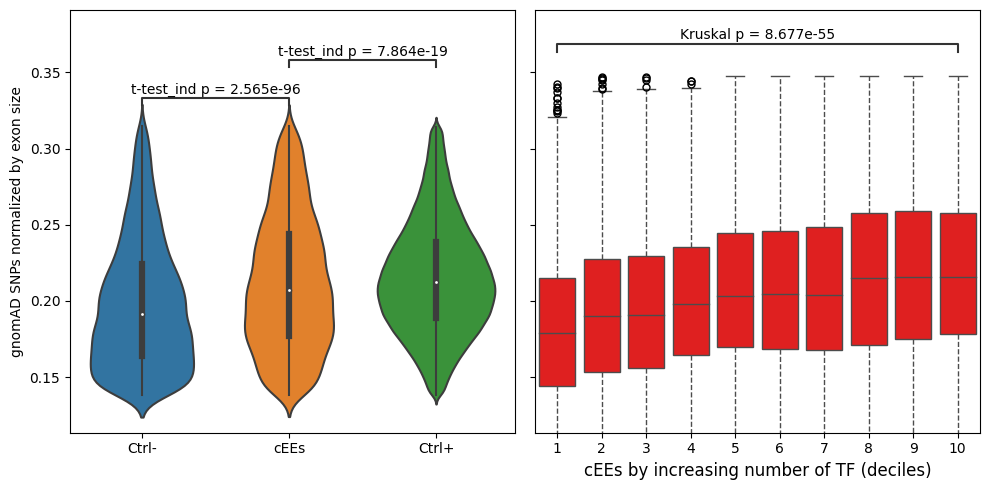

In [4]:
# Create a figure and two subplots (side by side)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5),sharey=True)

# --- First Plot: Violin Plot ---
sns.violinplot(x='Dataset', y='gnomAD_SNPs_norm', data=filtered_data, ax=ax1, order=["Ctrl-","cEEs","Ctrl+"])

# Add statistical annotations
add_stat_annotation(
    ax1,
    data=filtered_data,
    x='Dataset', y='gnomAD_SNPs_norm',
    box_pairs=[("cEEs", "Ctrl-"), ("cEEs", "Ctrl+")],
    test='t-test_ind',
    text_format='full',
    loc='inside',
    verbose=1, order=["Ctrl-","cEEs","Ctrl+"]
)

#ax1.set_title('gnomAD SNPs by EE')
ax1.set_ylabel('gnomAD SNPs normalized by exon size')
ax1.set_xlabel(None)

# --- Second Plot: Box Plot ---
sns.boxplot(
    data=df_ee_filtered,
    x='GroupByTF',
    y='gnomAD_SNPs_norm',
    color='red',
    showfliers=True,
    linewidth=1,
    whiskerprops={'linestyle': '--'},
    flierprops={
        'marker': 'o',
        'markerfacecolor': 'none',
        'markeredgecolor': 'black',
        'markersize': 5
    },
    ax=ax2  # Use ax2 for the second plot
)

add_stat_annotation(
                ax2, data=df_ee_filtered, x='GroupByTF', y="gnomAD_SNPs_norm",
                box_pairs=[(1, 10)],
                order=list(range(1, 11)),
                test='Kruskal',  # Kruskal-Wallis test
                text_format='full',
                loc='inside',
            )#verbose=0)

ax2.set_ylabel(None)
ax2.set_xlabel("cEEs by increasing number of TF (deciles)", fontsize=12)
ax2.tick_params(axis='x', labelsize=10)
ax2.tick_params(axis='y', labelsize=10)

fig.tight_layout()

plt.savefig("/home/mouren/Images/supplementary_figures/supp_fig7/gnomad_snps_ee.pdf", format="pdf", bbox_inches="tight", dpi=450)
plt.savefig("/home/mouren/Images/supplementary_figures/supp_fig7/gnomad_snps_ee.png", format="png", bbox_inches="tight", dpi=450)

plt.show()
